# 3️⃣ Custom CNN
    ✅ Trained From Scratch on Our Dataset
    ✅ Feature Extraction Power: Limited but customized for our dataset
    ✅ How it Works:

        Convolution layers → Detect patterns like edges, curves, etc.
        Pooling layers → Reduce image size while keeping important features.
        Fully connected layer → Extracts final feature vectors.

# Defining CNN Feature Extractor

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import os
import time
import cv2

In [2]:
# Enabling mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2050, compute capability 8.6


In [3]:
data_dir = r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\preprocessed'
img_size = (224,224)
batch_size = 32

# Data Augmentation 

In [4]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
    rotation_range = 15 # Only rotate image, no scaling or shifting
)

# Loading Data

In [5]:
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

Found 74004 images belonging to 5 classes.


In [6]:
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 18497 images belonging to 5 classes.


# Building the Custom CNN Model

In [7]:
model = Sequential([
    Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(64, (3,3), activation = 'relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(128,(3,3),activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax', dtype='float32') # 5 classes (0,1,2,3,4)
])

# Compiling the Model

In [8]:
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Training Callbacks

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3)

# Training the Custom CNN Model

In [12]:
print('Training CNN Model....')
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
    callbacks =[early_stopping, reduce_lr]
)
end_time = time.time()
print('Model training Completed')
print(f'Execution Time Taken: {end_time - start_time:.2f} seconds')

Training CNN Model....
Epoch 1/10
2313/2313 [==============================] - 1125s 486ms/step - loss: 0.7325 - accuracy: 0.7626 - val_loss: 0.8280 - val_accuracy: 0.7487 - lr: 1.0000e-04
Epoch 2/10
2313/2313 [==============================] - 1092s 472ms/step - loss: 0.7036 - accuracy: 0.7661 - val_loss: 0.8154 - val_accuracy: 0.7512 - lr: 1.0000e-04
Epoch 3/10
2313/2313 [==============================] - 1097s 474ms/step - loss: 0.6800 - accuracy: 0.7733 - val_loss: 0.7359 - val_accuracy: 0.7579 - lr: 1.0000e-04
Epoch 4/10
2313/2313 [==============================] - 1121s 484ms/step - loss: 0.6637 - accuracy: 0.7783 - val_loss: 0.6964 - val_accuracy: 0.7706 - lr: 1.0000e-04
Epoch 5/10
2313/2313 [==============================] - 1116s 482ms/step - loss: 0.6459 - accuracy: 0.7844 - val_loss: 0.6538 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 6/10
2313/2313 [==============================] - 1096s 474ms/step - loss: 0.6309 - accuracy: 0.7908 - val_loss: 0.8072 - val_accuracy: 0.761

# Saving the Model

In [13]:
model.save('DR_CNN_model.h5')

# Evaluating the Model

In [21]:
def evaluate_model():
    y_true = []
    y_pred = []
    
    steps = len(val_generator)  # Get total number of batches in validation set
    for _ in range(steps):
        images, labels = next(val_generator)  # Fetch next batch
        preds = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
    
    print('Confusion Matrix for CNN Model:')
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print('Classification Report for CNN Model:')
    print(classification_report(y_true, y_pred))


Confusion Matrix for CNN Model:


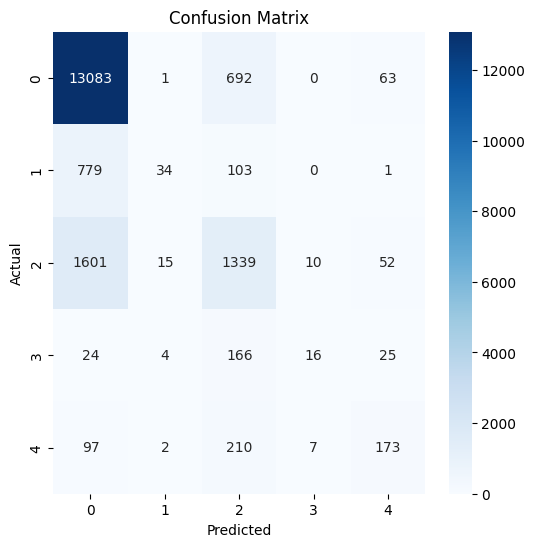

Classification Report for CNN Model:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     13839
           1       0.61      0.04      0.07       917
           2       0.53      0.44      0.48      3017
           3       0.48      0.07      0.12       235
           4       0.55      0.35      0.43       489

    accuracy                           0.79     18497
   macro avg       0.60      0.37      0.40     18497
weighted avg       0.77      0.79      0.76     18497



In [22]:
# Evaluating the CNN model
evaluate_model()

# Grad-CAM Visualization

In [76]:
def grad_cam(image_path, model, layer_name='conv2d_4'):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Error: Image not found at {image_path}")

    img = cv2.resize(img, (224, 224))  # Fix IMAGE_SIZE reference
    img = np.expand_dims(img, axis=0) / 255.0
    
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, np.argmax(predictions)]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0] * pooled_grads
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    plt.imshow(img[0])  # Display original image
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()


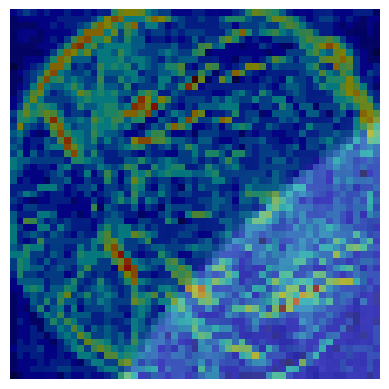

In [78]:
# Example Usage
grad_cam(r"C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\preprocessed\0\00cc2b75cddd.jpg",model)